In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
from numpy.core.defchararray import join,mod
import pandas as pd
import matplotlib.pyplot as plt
import  albumentations as A
import requests
from io import BytesIO
from PIL import Image
import random
import torch
from tqdm import tqdm
import  torch.nn as nn
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import random_split
from torchvision.transforms import ToPILImage

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
device

device(type='cuda')

In [4]:
def imgshow(number,title = None,size = 8):
    root = r"artifacts/raw/"
    image = cv2.imread(root+"Images/" + str(number)+ ".jpeg")

    file = open(root+"Labels/"+str(number)+ ".txt",'r')
    txt_data = file.readlines()
    file.close()

    for i in range(0,int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0] , indices[1])
        end_point = (indices[2], indices[3])

        cv2.rectangle(image,start_point,end_point,(0,0,255), 2)

    aspect_ratio = image.shape[0] / image.shape[1]

    plt.figure(figsize= (size + aspect_ratio , size))
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title(title+txt_data[0]) # type: ignore
    plt.axis("off")
    plt.show()

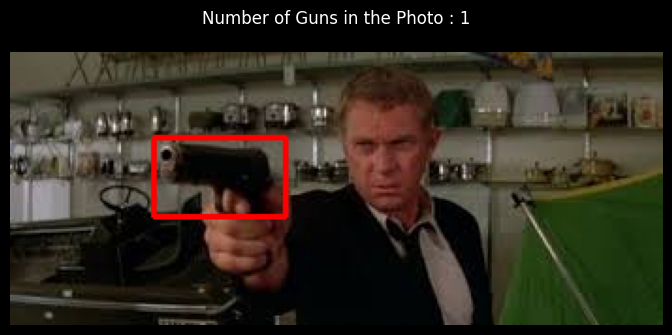

In [5]:
imgshow(1,title="Number of Guns in the Photo : ")

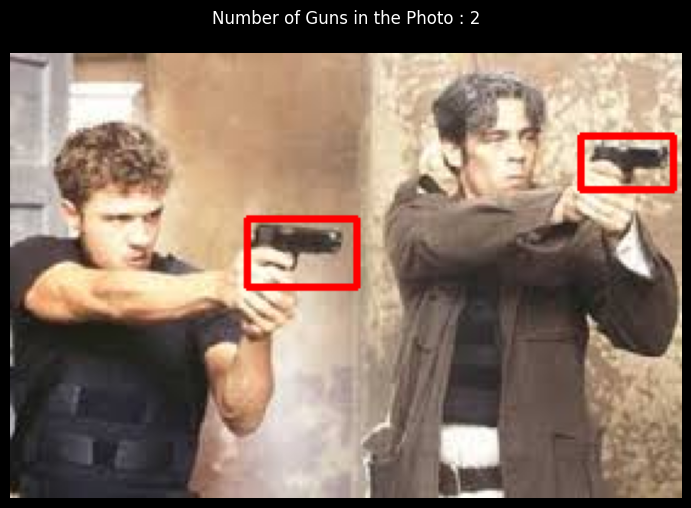

In [6]:
imgshow(239,title="Number of Guns in the Photo : ")

In [7]:
class Gun_Data(Dataset):
    def __init__(self,root):
        self.images_path = root + "Images/"
        self.labels_path = root + "Labels/"

        self.img_name = [img for img in sorted(os.listdir(self.images_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path,str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb / 255
        img_res = torch.as_tensor(img_res).permute(2,0,1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path,str(label_name))

        with open(label_path,'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split())))

        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target['boxes'] = torch.as_tensor(box)
        target['area'] = torch.as_tensor(area)
        target['image_id'] = torch.as_tensor([idx])
        target['labels'] = torch.as_tensor(labels,dtype=torch.int64)

        if torch.cuda.is_available():
            img_res = img_res.cuda()
            for key in target:
                if isinstance(target[key],torch.Tensor):
                    target[key] = target[key].cuda()

        return img_res,target

    def __len__(self):
        return len(self.img_name)


In [8]:
class Model:
    def __init__(self, num_classes):
        self.num = num_classes
        self.model = self.create_model()

    def create_model(self):
        # Load pre-trained Faster R-CNN and replace the classifier head
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)
        return model

    def compiler(self, optimizer):
        # Set optimizer
        self.optimizer = optimizer

    def train(self, train_data, val_data, num_epoch, device):
        # Move model to device
        self.model = self.model.to(device)

        for epoch in range(num_epoch):
            train_loss = 0.0
            self.model.train()

            # Progress bar for training batches
            pbar = tqdm(train_data, desc=f"Epoch {epoch + 1}", leave=False)

            for images, targets in pbar:
                # Move images and targets to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass and compute loss
                loss_dict = self.model(images, targets)
                loss = sum(loss for loss in loss_dict.values())

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                pbar.set_postfix({'Batch Loss': loss.item()})

            print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f}")

In [9]:
rcnn = Model(2)  # 2 classes: background + gun
model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epoch = 10
rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_Data(r"artifacts/raw/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:04<00:00, 38.1MB/s] 


In [10]:
rcnn.train(train_loader, val_loader, num_epoch=num_epoch, device=device)

Epoch 1 | Train Loss: 17.4258


Epoch 2 | Train Loss: 13.1719


Epoch 3 | Train Loss: 11.1699


Epoch 4 | Train Loss: 9.2528


Epoch 5 | Train Loss: 7.5502


Epoch 6 | Train Loss: 6.6498


Epoch 7 | Train Loss: 6.0565


Epoch 8 | Train Loss: 5.6639


Epoch 9 | Train Loss: 5.1577


Epoch 10 | Train Loss: 5.1678


In [ ]:
def test(data, number=None):
    if number is None:
        number = random.randint(1, len(data) - 1)

    img, target = data[number]

    # Move image and target to the correct device
    img = img.to(device)
    for key in target:
        if isinstance(target[key], torch.Tensor):
            target[key] = target[key].to(device)

    model.eval()
    with torch.no_grad():
        predictions = model([img])

    # Move predictions and image back to CPU
    for prediction in predictions:
        for key, value in prediction.items():
            prediction[key] = value.cpu()

    return predictions, target, img.cpu()

In [17]:
def apply_nms(original_predictions, iou_threshold=0.3):
    if iou_threshold is None:
        raise ValueError("iou_threshold must be a float between 0 and 1")

    keep = torchvision.ops.nms(
        original_predictions['boxes'],
        original_predictions['scores'],
        iou_threshold
    )

    final_prediction = {
        'boxes': original_predictions['boxes'][keep],
        'scores': original_predictions['scores'][keep],
        'labels': original_predictions['labels'][keep]
    }

    return final_prediction

In [18]:
def torch_to_pil(img):
    return ToPILImage()(img).convert("RGB")

In [19]:
def plot_img_bbox(img, target, size=8):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target['boxes']:
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        cv2.rectangle(img_cv, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0] / img_cv.shape[1]

    plt.figure(figsize=(size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [22]:
model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)  # 🔥 Move model to same device as input image
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
nms_predictions = apply_nms()

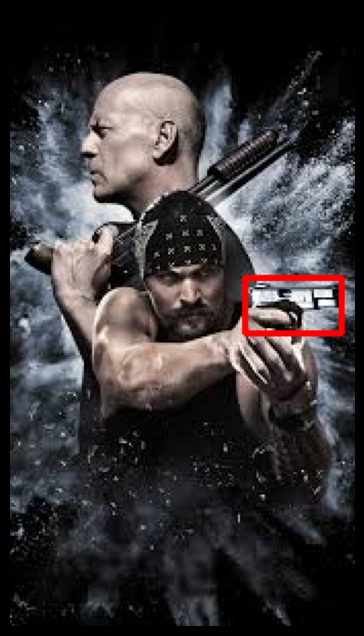

In [34]:
predictions, target, img = test(dataset, number=1)
img_pil = torch_to_pil(img)
predictions = apply_nms(predictions[0], iou_threshold=0.3)
plot_img_bbox(img_pil, predictions)

In [25]:
predictions

{'boxes': tensor([[ 18.3840,   6.3178,  70.7107,  57.8049],
         [127.3011,  23.4530, 148.6742,  62.0382]]),
 'scores': tensor([0.9971, 0.9949]),
 'labels': tensor([1, 1])}

In [23]:
torch.save(rcnn.model.state_dict(), f"model.pth")